WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
c:\Users\Kifiya_Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\arviz\__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(
C:\Users\Kifiya_Administrator\AppData\Local\Temp\ipykernel_13524\2407681600.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please spe

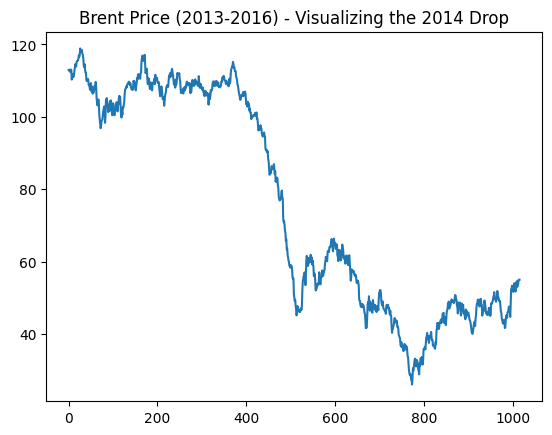

In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

# Load data
df = pd.read_csv('../data/BrentOilPrices.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.sort_values('Date', inplace=True)

# Select a specific window for the model (e.g., The 2014 Price Drop)
# This makes it easier to see the change point in action
data_subset = df[(df['Date'] >= '2013-01-01') & (df['Date'] <= '2016-12-31')].copy()
data_subset.reset_index(drop=True, inplace=True)

# Plot the subset to visualize what the model sees
plt.plot(data_subset['Price'])
plt.title("Brent Price (2013-2016) - Visualizing the 2014 Drop")
plt.show()

# Get the price as a numpy array
prices = data_subset['Price'].values
n_data = len(prices)

In [2]:
with pm.Model() as change_point_model:
    # Prior for the switchpoint (it could happen at any day in the dataset)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_data - 1)
    
    # Priors for the mean prices
    mu_1 = pm.Normal("mu_1", mu=prices.mean(), sigma=prices.std())
    mu_2 = pm.Normal("mu_2", mu=prices.mean(), sigma=prices.std())
    
    # Standard deviation of the price (can be shared or separate)
    sigma = pm.Exponential("sigma", lam=1.0)
    
    # Logic: If current index < tau, use mu_1, else use mu_2
    idx = np.arange(n_data)
    mu_ = pm.math.switch(tau >= idx, mu_1, mu_2)
    
    # Likelihood (how the model sees the data)
    observation = pm.Normal("obs", mu=mu_, sigma=sigma, observed=prices)

    # Inference: Running the MCMC sampler
    # This might take a minute
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 704 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


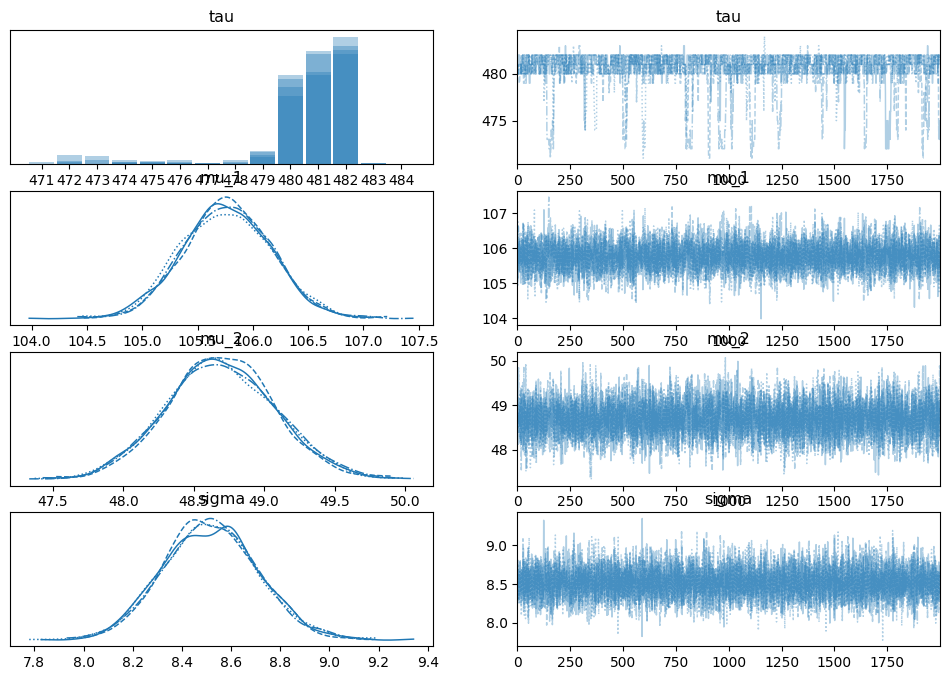

         mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_1  105.766  0.402  104.994  106.483      0.006    0.005    4581.0   
mu_2   48.694  0.385   47.965   49.419      0.005    0.004    5377.0   
tau   480.700  1.811  479.000  482.000      0.087    0.159     708.0   

      ess_tail  r_hat  
mu_1    4545.0   1.00  
mu_2    3786.0   1.00  
tau      450.0   1.01  

The model detected a significant change point on: 2014-11-25 00:00:00


In [3]:
# Trace plot: Check if the model converged (curves should be smooth)
az.plot_trace(trace)
plt.show()

# Summary statistics for mu_1, mu_2, and tau
print(az.summary(trace, var_names=["mu_1", "mu_2", "tau"]))

# Map Tau back to a Date
tau_samples = trace.posterior['tau'].values.flatten()
most_likely_tau = int(np.median(tau_samples))
change_date = data_subset.iloc[most_likely_tau]['Date']

print(f"\nThe model detected a significant change point on: {change_date}")

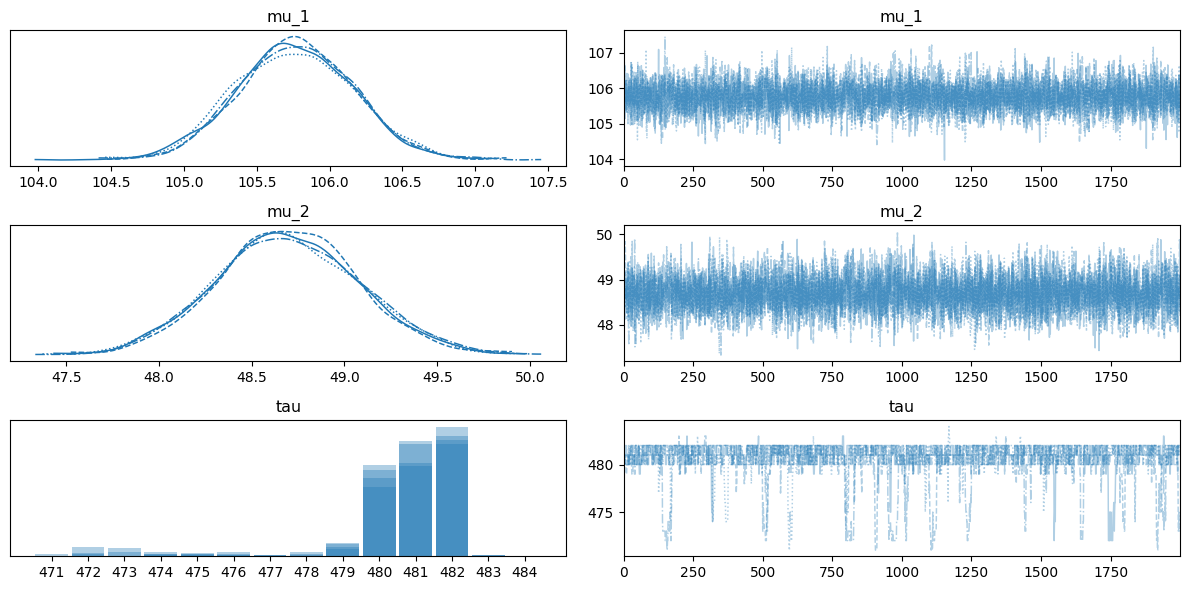

         mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_1  105.766  0.402  104.994  106.483      0.006    0.005    4581.0   
mu_2   48.694  0.385   47.965   49.419      0.005    0.004    5377.0   
tau   480.700  1.811  479.000  482.000      0.087    0.159     708.0   

      ess_tail  r_hat  
mu_1    4545.0   1.00  
mu_2    3786.0   1.00  
tau      450.0   1.01  


In [4]:
# 1. Plot the Trace
az.plot_trace(trace, var_names=["mu_1", "mu_2", "tau"])
plt.tight_layout()
plt.show()

# 2. Get the specific statistics
summary = az.summary(trace, var_names=["mu_1", "mu_2", "tau"])
print(summary)

In [5]:
# Map the 'tau' index back to a real date
tau_mean = int(summary.loc['tau', 'mean'])
detected_date = data_subset.iloc[tau_mean]['Date']

# Get the price means
price_before = summary.loc['mu_1', 'mean']
price_after = summary.loc['mu_2', 'mean']
percent_change = ((price_after - price_before) / price_before) * 100

print(f"--- INSIGHTS ---")
print(f"Detected Change Point Date: {detected_date.strftime('%Y-%m-%d')}")
print(f"Price Before: ${price_before:.2f}")
print(f"Price After: ${price_after:.2f}")
print(f"Impact: {percent_change:.2f}% change in average price.")

--- INSIGHTS ---
Detected Change Point Date: 2014-11-24
Price Before: $105.77
Price After: $48.69
Impact: -53.96% change in average price.


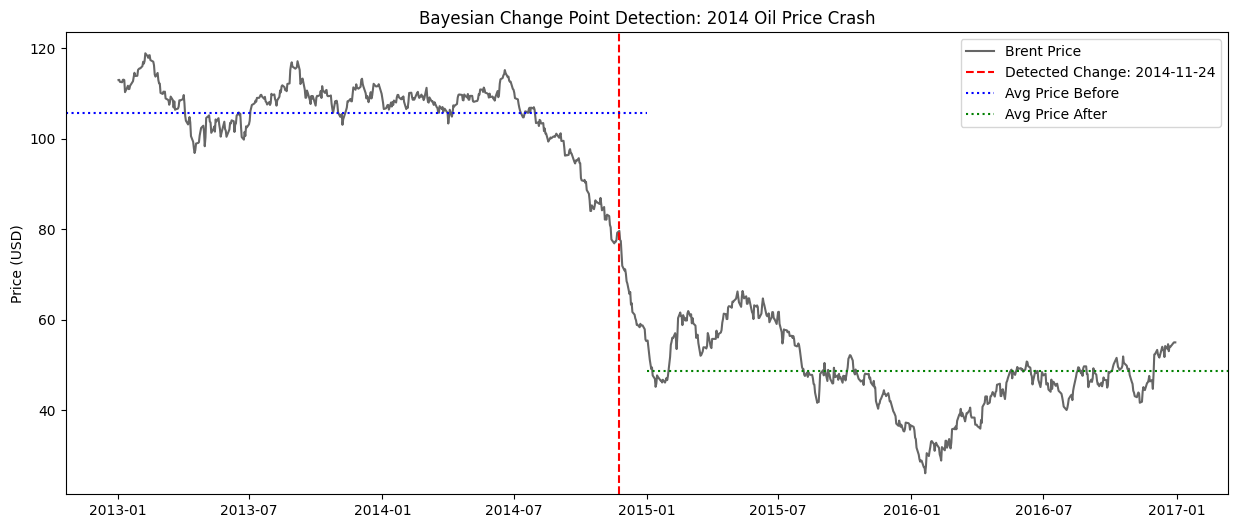

In [6]:
plt.figure(figsize=(15, 6))
plt.plot(data_subset['Date'], data_subset['Price'], label='Brent Price', color='black', alpha=0.6)
plt.axvline(detected_date, color='red', linestyle='--', label=f'Detected Change: {detected_date.strftime("%Y-%m-%d")}')

# Add shaded areas for mu_1 and mu_2 levels
plt.axhline(price_before, xmin=0, xmax=0.5, color='blue', linestyle=':', label='Avg Price Before')
plt.axhline(price_after, xmin=0.5, xmax=1, color='green', linestyle=':', label='Avg Price After')

plt.title("Bayesian Change Point Detection: 2014 Oil Price Crash")
plt.legend()
plt.ylabel("Price (USD)")
plt.show()